This notebook generates ballot-, candidate-, and party-MDS plots from the paper.

In [22]:
import glob
from sklearn.manifold import MDS
import numpy as np
import seaborn as sns

import sys
sys.path.append('..')
from Clustering_Functions import *
import warnings

warnings.filterwarnings('ignore')

BALLOT MDS PLOTS FROM PENTLAND HILLS

In [3]:
filename = '../scot-elex/7_cands/edinburgh_2017_ward2.csv'
num_cands, election, cand_list, ward = csv_parse(filename)
parties = party_abrevs(cand_list)

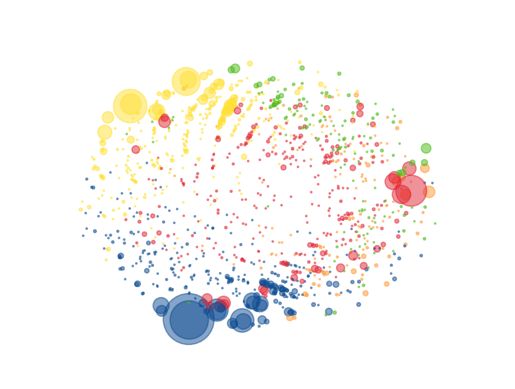

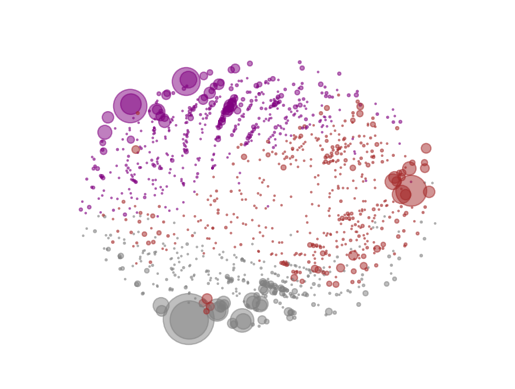

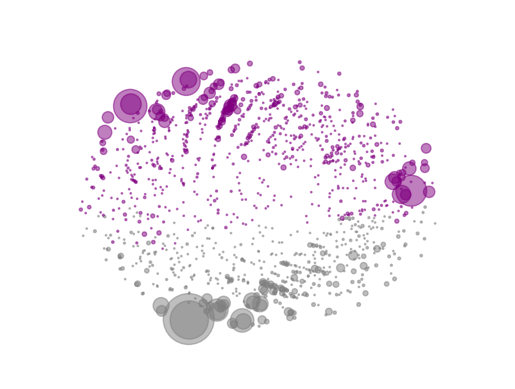

In [25]:
# Create ballot MDS plot of Pentland Hills
# colored in 3 different ways with a common projection.
C2 = kmeans(election, k=2)
C3 = kmeans(election, k=3)

projections, error = Ballot_MDS_plot(election, party_names=parties, return_data=True, threshold = 1) #colored by party of first place vote
Ballot_MDS_plot(election, C3, projections=projections, threshold=1) #colored by 3-means assignment
Ballot_MDS_plot(election, C2,projections=projections, threshold=1) # colored by 2-means assignment

CANDIDATE MDS PLOT FOR PENTLAND HILLS

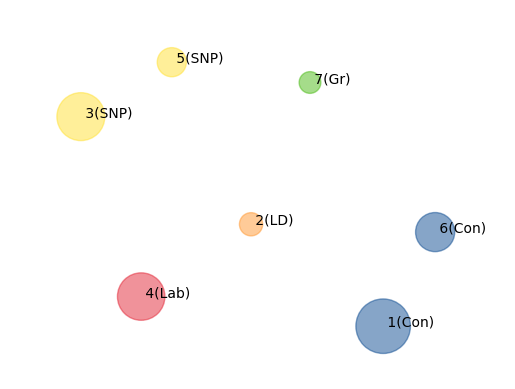

In [7]:
Candidate_MDS_plot(election, party_names=parties, party_colors='Auto', filename = None)

PARTY MDS PLOT FOR PENTLAND HILLS

Next we'll create an MDS plot for the five major parties.  The distance between two parties is the average distance between candidates from those two parties running against each other (over all such candidate pairs in all elections).  We'll size the markers by the portion of first place votes that the party received (over all elections).

In [8]:
top_parties = ['SNP', 'Lab', 'Con', 'LD', 'Gr']
party_colors = D = ['#FFE135', '#E32636', '#0F4D92', '#FF9933', '#4CBB17']

In [19]:
def Party_MDS_plot(filename_list = 'Auto', method = 'borda_completion', trunc = None, dimension = 2, 
                   marker_scale = 5000, filename=None):
    if filename_list == 'Auto':
        filename_list = glob.glob("../scot-elex/**/*.csv")

    # Generate first place vote tallies and pairwise distances.
    pair_counts =  pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)
    distances =    pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)
    party_fpv_counts = {party:0 for party in top_parties}

    for file in filename_list:
        num_cands, election, cand_names, location = csv_parse(file)
        party_list = party_abrevs(cand_names)
        
        # tally party first place votes
        for ballot, weight in election.items():
            party = party_list[ballot[0]-1]
            if party in top_parties:
                party_fpv_counts[party]+=weight
        
        # create pairwise distance matrix
        M = Candidate_dist_matrix(election, method = method, trunc=trunc)
        for i in range(len(party_list)):
            for j in range(len(party_list)):
                if i != j:
                    pi = party_list[i]
                    pj = party_list[j]
                    if pi in top_parties and pj in top_parties:
                        weight = M[i,j]
                        distances[pi][pj] += weight/num_cands
                        pair_counts[pi][pj] +=1
    total = sum(party_fpv_counts.values())
    party_fpv_counts={x:y/total for x,y in party_fpv_counts.items()}
    M = distances/pair_counts
    M = M.fillna(value=0.01)

    # Next generate the MDS plot
    projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(M)

    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) if dimension==2 else np.array([0 for _ in range(len(projections))])

    fig, ax = plt.subplots()

    s = [marker_scale*party_fpv_counts[party] for party in top_parties]

    ax.scatter(X,Y, s=s, c = party_colors,alpha=.5)
    for count in range(len(top_parties)):
        ax.annotate(f" {top_parties[count]}", xy=(X[count], Y[count]))

    x_margin = (max(X) - min(X)) * 0.2  # 20% margin
    y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
    plt.xlim(min(X) - x_margin, max(X) + x_margin)
    plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
    ax.grid(False)
    ax.axis('off')
    if filename != None:
        plt.savefig(filename, dpi=300)
    plt.show()

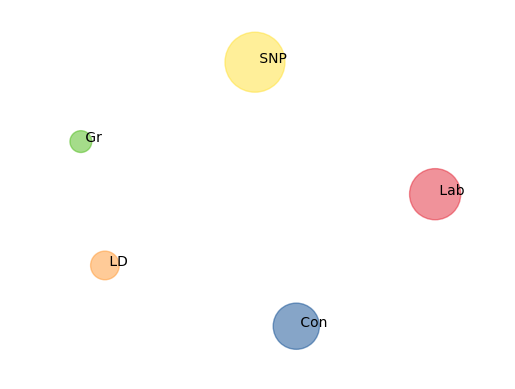

In [15]:
Party_MDS_plot(filename=None)

In [16]:
# Check number of elections in each year
for year in [2012, 2017, 2022]:
    test = glob.glob(f"../scot-elex/**/*{year}*.csv")
    print(f'{year}: {len(test)} elections')

2012: 353 elections
2017: 351 elections
2022: 345 elections


Create a separate party MDS plot for each year, and this time make the plots 1-dimensional.

2012


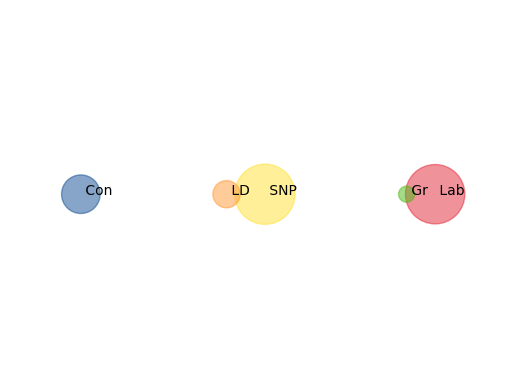

2017


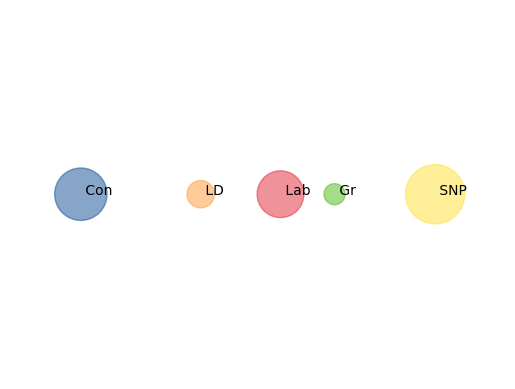

2022


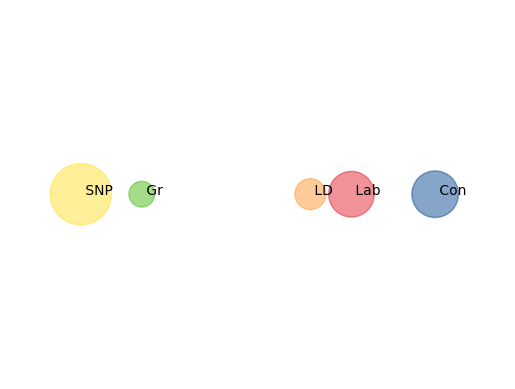

In [24]:
for year in [2012, 2017, 2022]:
    filename_list = glob.glob(f"../scot-elex/**/*{year}*.csv")
    print(year)
    Party_MDS_plot(filename_list=filename_list, method = 'borda', dimension=1)

We can't necessarily put much trust in 1D MDS projections, but still the shift over time seems interesting here.